## Train DML Models for CDS Option Pricing 

In [203]:
# Library requirements 
import pandas as pd
import numpy as np
import time 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

%run dml_models.ipynb
%run plotting.ipynb


## Config Settings  

Configuration settings for Model, Data and Control;   

-   **Model**:   Controlling which model to train with (or load a saved model)  
-   **Data**:    Specify the training features and gradients to use and the target label  
-   **Control**: Specify how to normalise the data, how many training epochs, if subsampling and what metric to use. 


In [156]:
# Model Config

config = dict(# Model
              model = 'model_dml_BN',      # model version 
              train_or_load = 'load',      # (train, load) 
              model_path ='./saved_dml_models/', 
              model_save_name = '',        # train_or_load == 'train'
              model_load_name = 'model_dml_BN_xf(20_20_20_20_1_KIG_E8000_1e5_SP)_(s_t_k_iv)_norm_(option_contracts_dense_sublonger_all)', # train_or_load == 'load'

              # Data 
              data_path = "./../../data/", 
              data_name = "option_priced_dense_fd.csv",                           # (option_priced_fd.csv) fd for first derivatives  
              X = ('spread', 'exp_duration', 'strike', 'impliedVol'),     # features to train on 
              y = ('mtm',),                                                       # y label 
              dydx = ('delta', 'theta', 'deltastrike', 'vega'),      # gradients to train on 

              # Control Parameters 
              epochs = 1000,
              apply_sampling = True,
              apply_rounding = True,
              loss = 'mean_squared_error'      # (mean_absolute_error, mean_squared_error)
)


## Load and Sample Data   

Load the training data and filter for only what we need for model training. 

In [128]:
# Read the CDS Index contracts 
data_orig = pd.read_csv(config['data_path'] + config['data_name'])
#data = data[(data.recovery == 0.4) & (data.coupon == 100) & (data.val_date < '2025-05-30') ] 
data_orig = data_orig[(data_orig.recovery == 0.4) & (data_orig.coupon == 100) & (data_orig.maturity == '2029-06-20') & (data_orig.optionType == 1)] 
data = data_orig[list(config['X'] + config['dydx'] + config['y'])]

if config['apply_sampling']:
    # add any subsampling required here ...  
    # ignore contracts which are almost worthless and near zero vega graadients 
    sampled_data = data[(data.mtm.abs() > 0.0009)].copy()
    sampled_data = sampled_data[(sampled_data.vega > 1e-5)]

else:
    sampled_data = data.copy() 

if (config['apply_rounding']):    
    sampled_data.loc[:,['mtm', 'spread', 'exp_duration', 'strike', 'impliedVol', 'delta', 'theta', 'deltastrike', 'vega']] = \
        sampled_data.loc[:,['mtm', 'spread', 'exp_duration', 'strike', 'impliedVol', 'delta', 'theta', 'deltastrike', 'vega']].round(8)  

sampled_data


,spread,exp_duration,strike,impliedVol,delta,theta,deltastrike,vega,mtm
9,0.005032,0.133333,0.003734,0.303473,4.733724,0.005032,-4.646665,0.000040,0.006704
11,0.005032,0.230556,0.003734,0.303473,4.705913,0.005091,-4.509504,0.000228,0.007086
13,0.005032,0.055556,0.003734,0.509475,4.719450,0.005301,-4.704791,0.000072,0.006406
15,0.005032,0.133333,0.003734,0.509475,4.582501,0.006069,-4.427708,0.000646,0.006765
17,0.005032,0.230556,0.003734,0.509475,4.443930,0.006252,-4.115723,0.001411,0.007252
...,...,...,...,...,...,...,...,...,...
3637533,0.009238,0.016667,0.010365,1.305792,1.237265,0.073653,-1.005297,0.001775,0.001108
3637535,0.009238,0.016667,0.010365,1.500000,1.384679,0.089287,-1.105370,0.001868,0.001462
3637537,0.009238,0.016667,0.010365,1.701940,1.511897,0.105062,-1.184799,0.001933,0.001846
3637539,0.009238,0.016667,0.010365,1.902750,1.618719,0.120333,-1.245278,0.001979,0.002239


## Preprocess Data  

Separate the data into input features (X), input gradients (dydx) and target label (y).  
Create a train:test split.  
Define function for preprocessing the data (normalisation and creation of custom gradient loss function).  
Define function for reversing the normlisation.  

In [129]:
X = sampled_data[list(config['X'])]
y = sampled_data[list(config['y'])].values.reshape(-1, 1)
dydx = sampled_data[list(config['dydx'])]

# Split into training and testing sets
X_train, X_true, y_train, y_true, dydx_train, dydx_true = train_test_split(X, y, dydx, test_size=0.2, random_state=42)

## Build and Compile or Load a Model 

In [132]:
if config['train_or_load'] == 'train':
    tf.keras.backend.clear_session()

    # Constants 
    differential_weight = 2
    STEPS_PER_EPOCH = 16
    BATCH_SIZE = 1024
    EPOCHS = 30000   # config override 

    # Create a time decaying learning rate schedule 
    lr_inv_time_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=STEPS_PER_EPOCH*100,
        decay_rate=50,
        staircase=False)

    # Preprocess data and build the model
    prep_layer, grad_loss = preprocess_data(X_train.values, y_train, dydx_train.values, prep_type='Normalisation')
    model = build_and_compile_model(prep_layer.output_n(),
                                    config['model'], 
                                    grad_loss, 
                                    differential_weight,
                                    lr_schedule=lr_inv_time_decay  # lr_inv_time_decay 
                                    )

    # Train the model
    start_time = time.time()
    history = train_model(model,
                            prep_layer,
                            X_train.values, 
                            y_train, 
                            dydx_train.values, 
                            epochs=EPOCHS,
                            batch_size = BATCH_SIZE,
                            x_true=X_true.values, 
                            y_true=y_true, 
                            dydx_true=dydx_true.values
                            )
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    model.save(config['model_path'] + config['model_save_name'])

elif config['train_or_load'] == 'load':
    prep_layer, grad_loss = preprocess_data(X_train.values, y_train, dydx_train.values, prep_type='Normalisation')
    model = load_model(config['model_path'] + config['model_load_name'], custom_objects={'grad_custom_loss': grad_loss})

else:
    raise ValueError(f"Unrecognized value for 'train_or_load': {config['train_or_load']}. Expected 'train' or 'load'.")




## Evaluate the Model  

Evaluate the model on the test set and create dataframes useful for analysing the distribution and size of relative and absolute accuracy of ground truth vs predicted MtMs, Deltas, Thetas, DeltaStrike and Vega.     

185/185 [==============================] - 0s 1ms/step
Mean Squared Error on mtm test set: 2.23747051260885e-08
Mean Squared Error on cs01 test set: 0.04156140416462171
Mean Squared Error on theta test set: 1.6794668614826237e-05
Mean Squared Error on theta test set: 0.0260934825278125
Mean Squared Error on theta test set: 2.422052589831572e-07


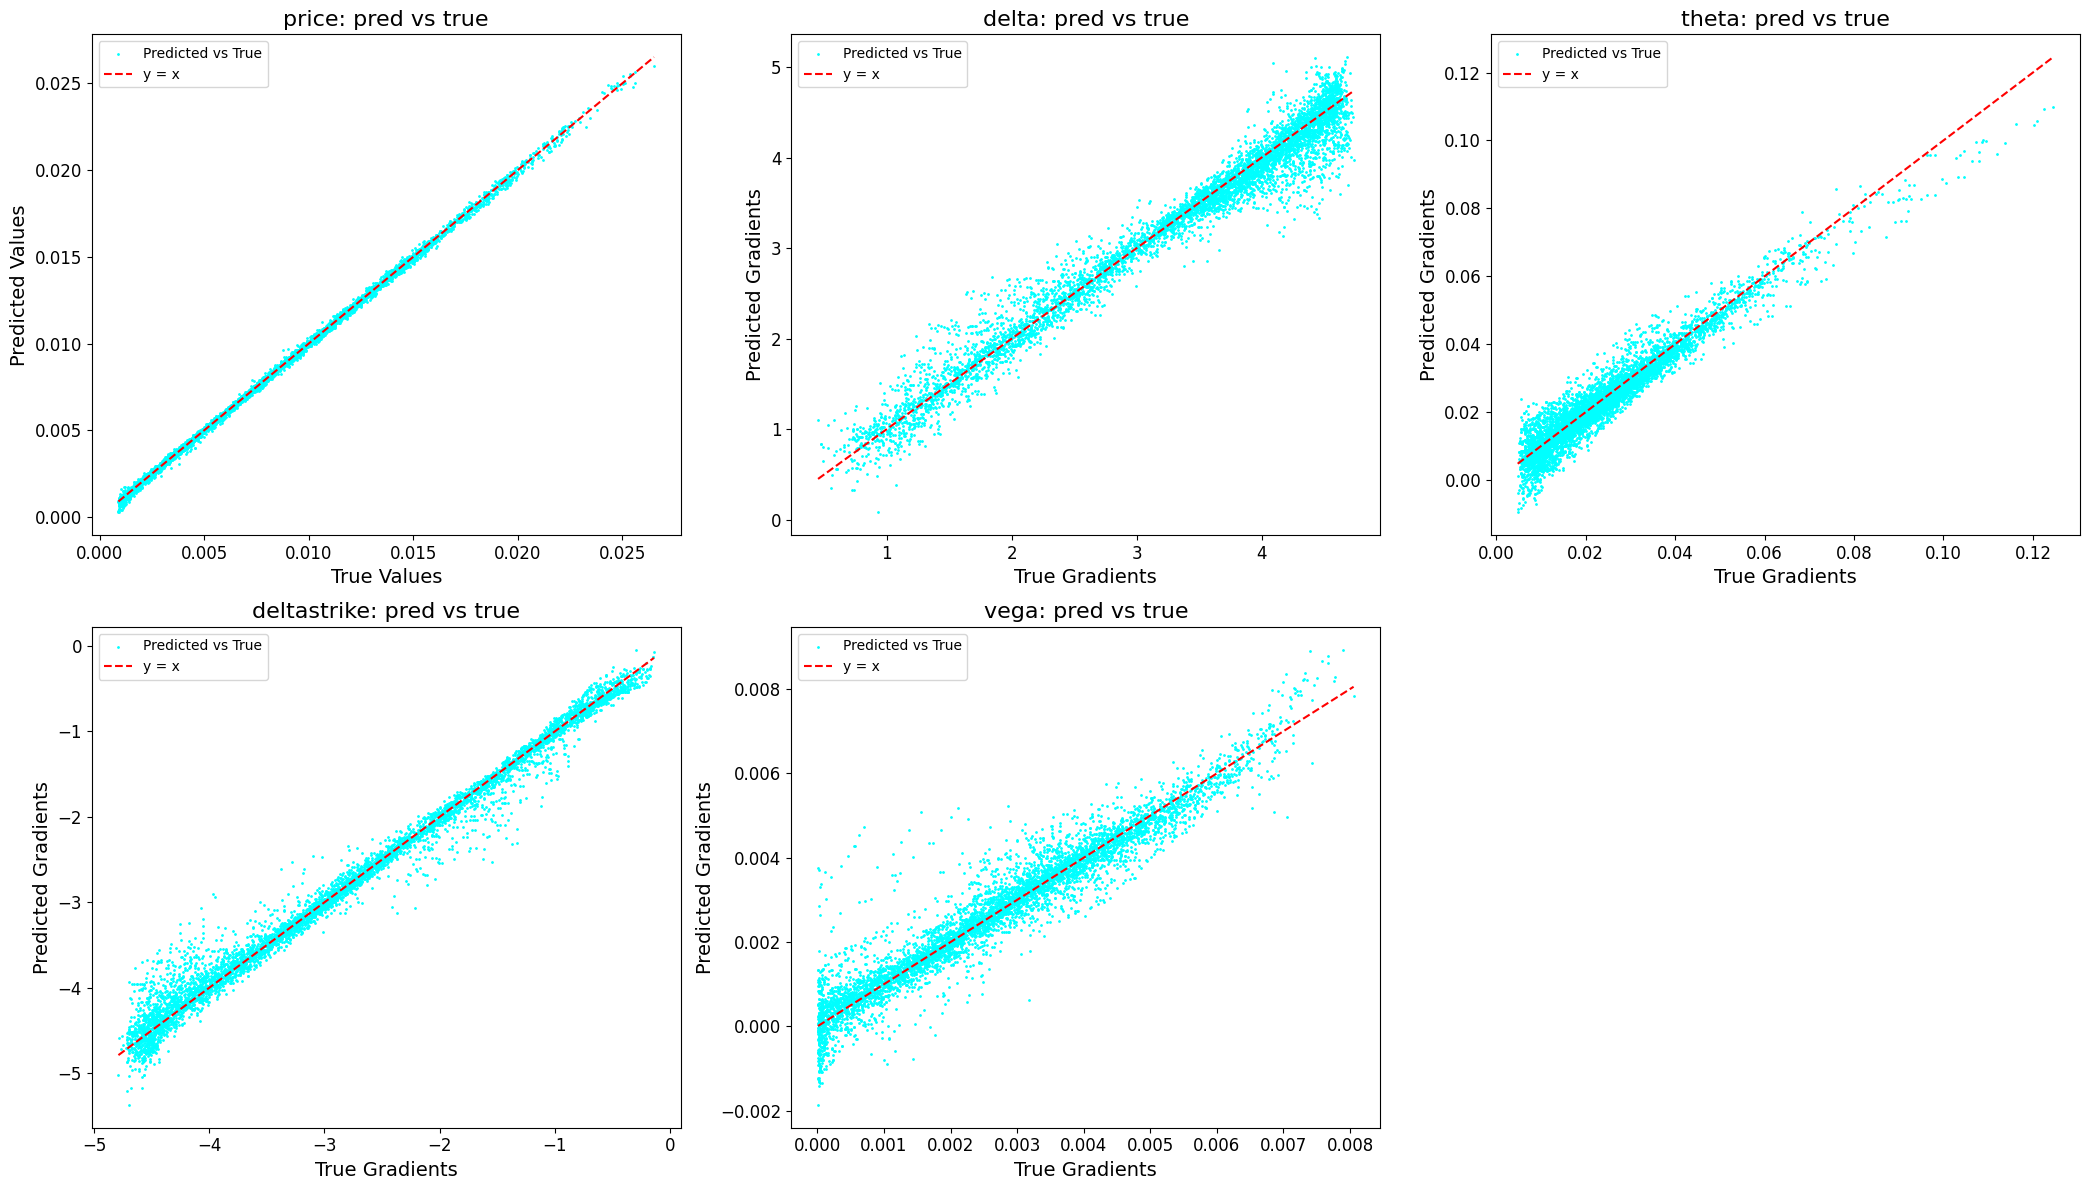

In [196]:
# Predict and store results
y_pred, dydx_pred = predict_unscaled(model, prep_layer, X_true.values)
pred_values = y_pred
pred_deltas = dydx_pred

mse_y = mean_squared_error(y_true, y_pred)
mse_delta = mean_squared_error(dydx_true.iloc[:, 0], dydx_pred[:, 0])
mse_theta = mean_squared_error(dydx_true.iloc[:, 1], dydx_pred[:, 1])
mse_deltastrike = mean_squared_error(dydx_true.iloc[:, 2], dydx_pred[:, 2])
mse_vega = mean_squared_error(dydx_true.iloc[:, 3], dydx_pred[:, 3])
print(f'Mean Squared Error on mtm test set: {mse_y}')
print(f'Mean Squared Error on cs01 test set: {mse_delta}')
print(f'Mean Squared Error on theta test set: {mse_theta}')
print(f'Mean Squared Error on theta test set: {mse_deltastrike}')
print(f'Mean Squared Error on theta test set: {mse_vega}')

# Utility to prepare data frames of true and predicted values of the model 
def prepare_results(true, pred, true_name, pred_name, flatten=True):
    if flatten:
        true = true.flatten()
        pred = pred.flatten()

    df = pd.DataFrame({
        true_name: true,
        pred_name: pred
    })
    df['diff_rel'] = (df[true_name] - df[pred_name]) / df[true_name] * 100
    df['diff_abs'] = (df[true_name] - df[pred_name]) 

    return df

df_mtm = prepare_results(y_true, y_pred, 'y_true', 'y_pred')
df_delta = prepare_results(dydx_true.iloc[:, 0], dydx_pred[:, 0], 'delta_true', 'delta_pred', flatten=False)
df_theta = prepare_results(dydx_true.iloc[:, 1], dydx_pred[:, 1], 'theta_true', 'theta_pred', flatten=False)
df_deltastrike = prepare_results(dydx_true.iloc[:, 2], dydx_pred[:, 2], 'deltastrike_true', 'deltastrike_pred', flatten=False)
df_vega = prepare_results(dydx_true.iloc[:, 3], dydx_pred[:, 3], 'vega_true', 'vega_pred', flatten=False)

plot_option_dml_fit(y_true, y_pred, dydx_true, dydx_pred, 'price', 'delta', 'theta', 'deltastrike', 'vega')

#df_mtm

## Prediction Errors   

Analyse the prediction relative and absolute prediction accuracy across MtM bins and uniformly across the entire test set for MtM and gradients Delta, Theta, DeltaStrike and Vega.   

### MtM

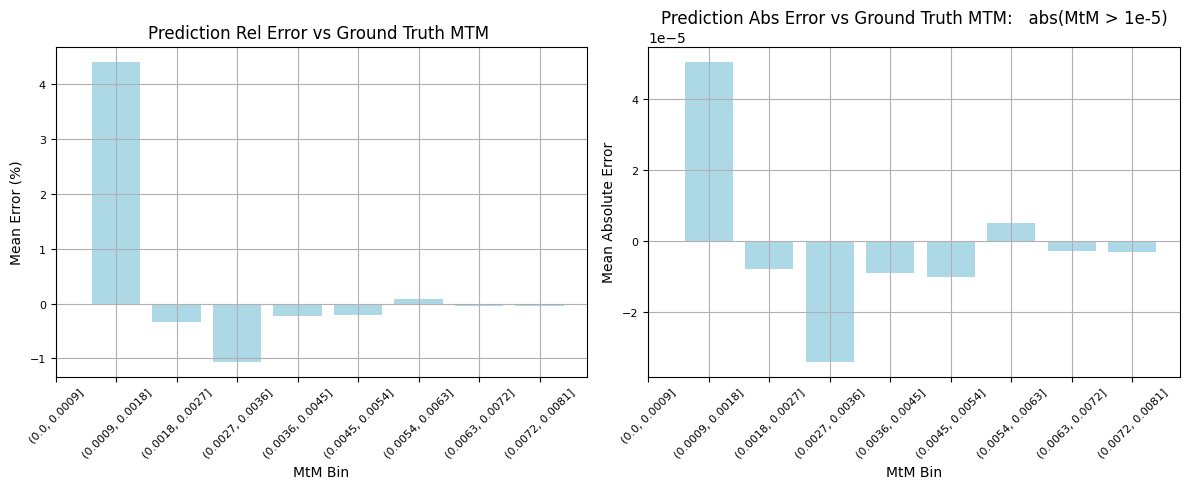

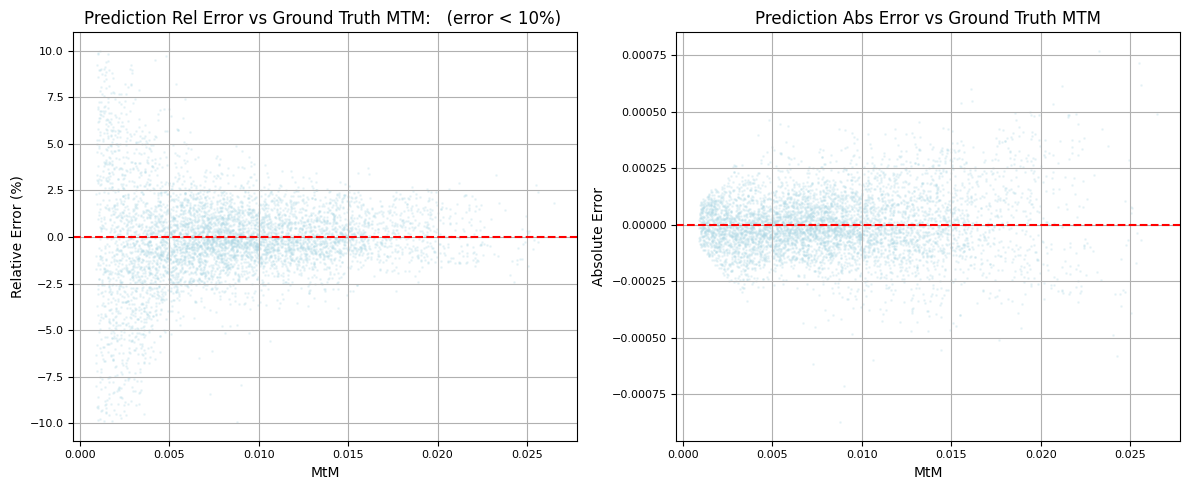

,mtm_bin,diff_rel
0,"(0.0, 0.0009]",NaN
1,"(0.0009, 0.0018]",4.409634
2,"(0.0018, 0.0027]",-0.332022
3,"(0.0027, 0.0036]",-1.057378
4,"(0.0036, 0.0045]",-0.226349
5,"(0.0045, 0.0054]",-0.199301
6,"(0.0054, 0.0063]",0.082429
7,"(0.0063, 0.0072]",-0.043289
8,"(0.0072, 0.0081]",-0.043274


In [135]:
# Mean percentage prediction error across MtM bins 
df_mtm['y_test'] = df_mtm['y_true']
bin_errors = plot_pred_error_rel_twice(df_mtm, df_mtm, 'opt_vega', 'Prediction Rel Error vs Ground Truth MTM ', 'Prediction Abs Error vs Ground Truth MTM:   abs(MtM > 1e-5)')

# Relative and absolute prediction errors (no bins) 
df = df_mtm[abs(df_mtm['diff_rel']) < 10]
plot_pred_error_twice(df , df, '', 'Prediction Rel Error vs Ground Truth MTM:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth MTM', size=1)
bin_errors[0]

### Delta

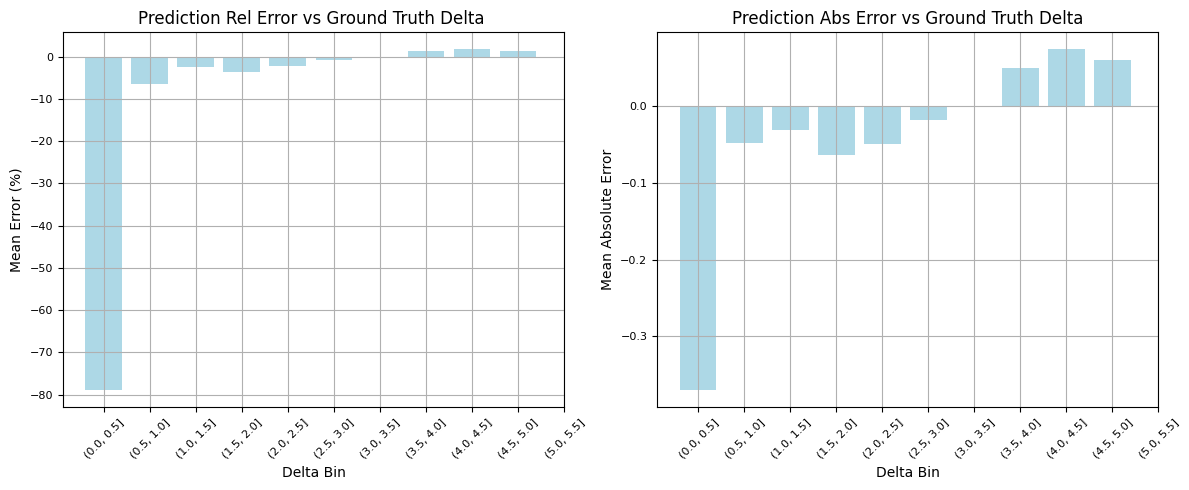

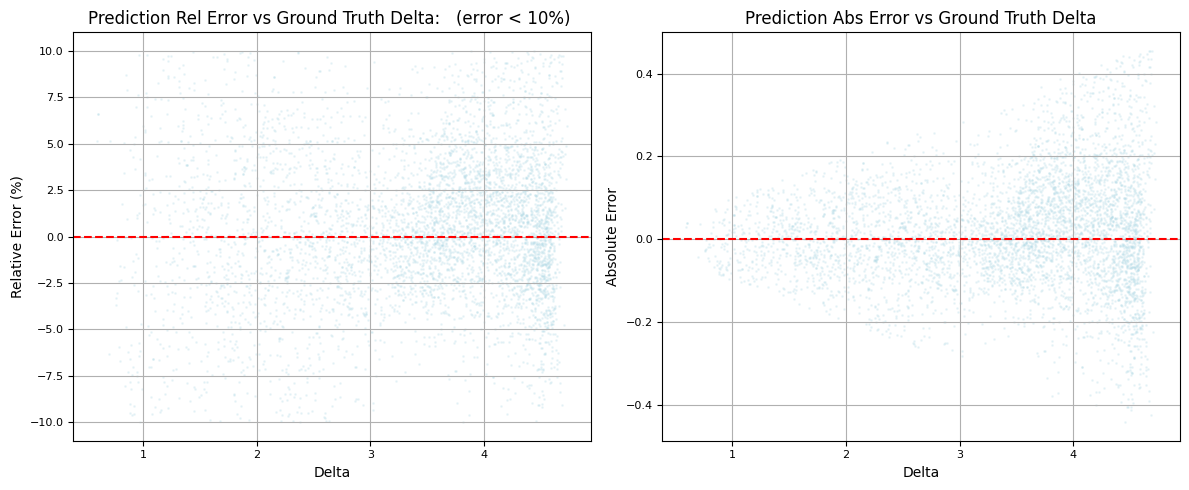

,mtm_bin,diff_rel
0,"(0.0, 0.5]",-79.009213
1,"(0.5, 1.0]",-6.514377
2,"(1.0, 1.5]",-2.318968
3,"(1.5, 2.0]",-3.661122
4,"(2.0, 2.5]",-2.213809
5,"(2.5, 3.0]",-0.679993
6,"(3.0, 3.5]",0.001289
7,"(3.5, 4.0]",1.302298
8,"(4.0, 4.5]",1.736796
9,"(4.5, 5.0]",1.296709


In [136]:
# Mean percentage prediction error across MtM bins 
df_delta['y_test'] = df_delta['delta_true']
bin_errors = plot_pred_error_rel_twice(df_delta, df_delta, 'opt_delta', 'Prediction Rel Error vs Ground Truth Delta ', 'Prediction Abs Error vs Ground Truth Delta', x='Delta Bin')

# Relative and absolute prediction errors (no bins) 
df = df_delta[abs(df_delta['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'opt_delta', 'Prediction Rel Error vs Ground Truth Delta:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth Delta', size = 1, x='Delta')
bin_errors[0]

### Theta 

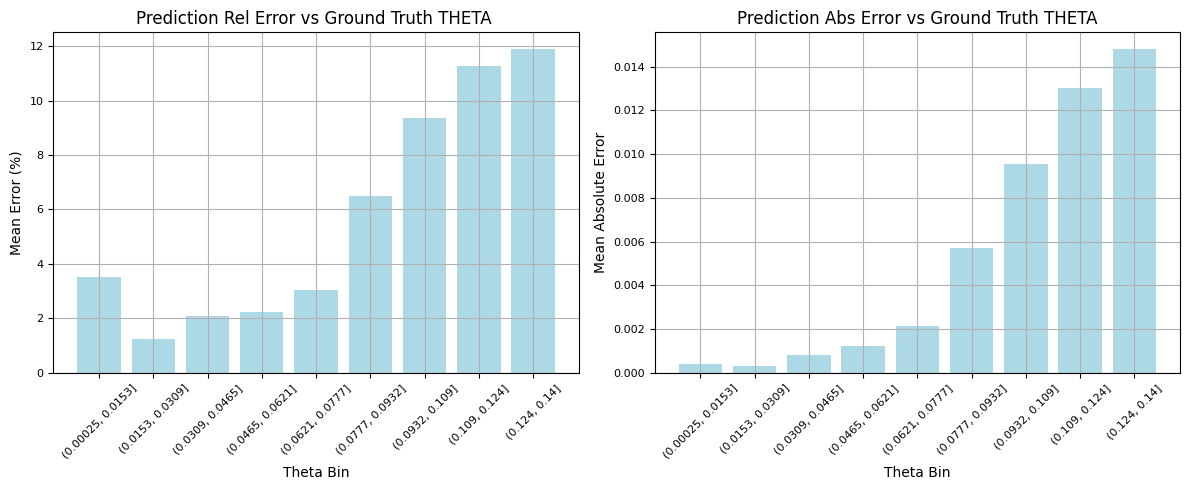

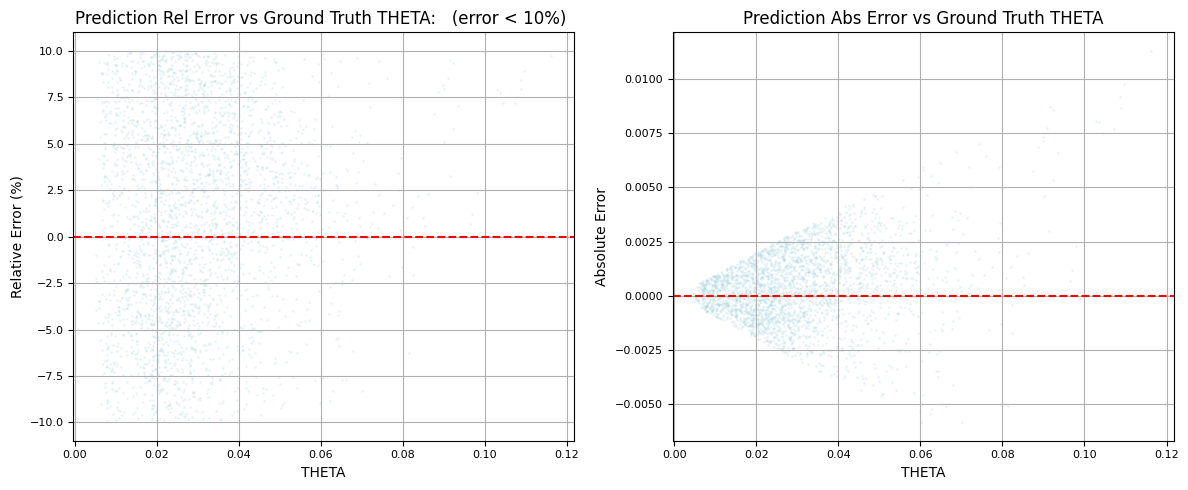

,mtm_bin,diff_rel
0,"(0.00025, 0.0153]",3.521707
1,"(0.0153, 0.0309]",1.254426
2,"(0.0309, 0.0465]",2.092521
3,"(0.0465, 0.0621]",2.242685
4,"(0.0621, 0.0777]",3.060511
5,"(0.0777, 0.0932]",6.490294
6,"(0.0932, 0.109]",9.351851
7,"(0.109, 0.124]",11.257266
8,"(0.124, 0.14]",11.907775


In [137]:
# Mean percentage prediction error across MtM bins 
df_theta['y_test'] = df_theta['theta_true']
bin_errors = plot_pred_error_rel_twice(df_theta, df_theta, 'opt_theta', 'Prediction Rel Error vs Ground Truth THETA ', 'Prediction Abs Error vs Ground Truth THETA', x='Theta Bin')

# Relative and absolute prediction errors (no bins)  
df = df_theta[abs(df_theta['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'opt_theta', 'Prediction Rel Error vs Ground Truth THETA:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth THETA', size = 1, x='THETA')
bin_errors[0]

### DeltaStrike

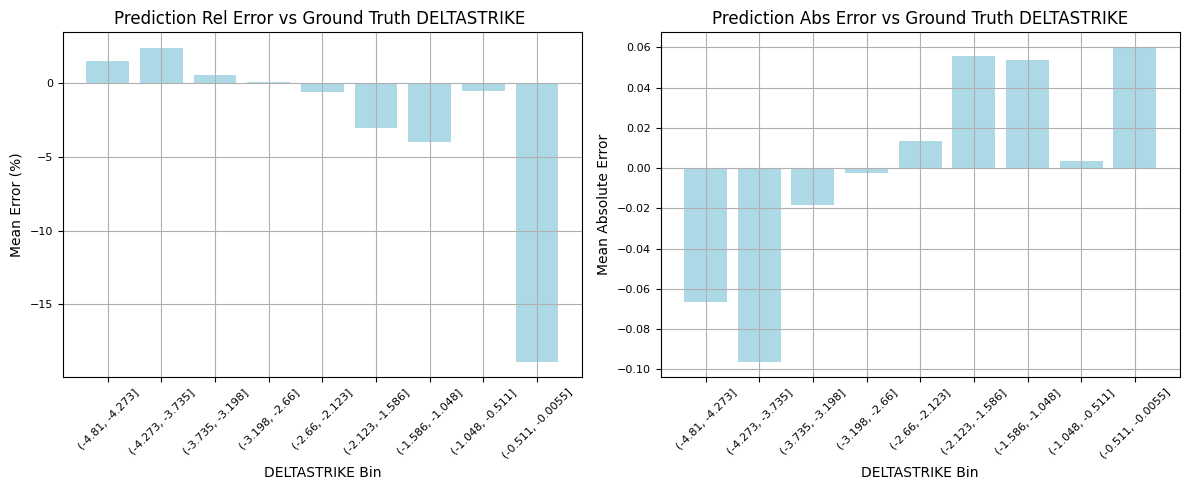

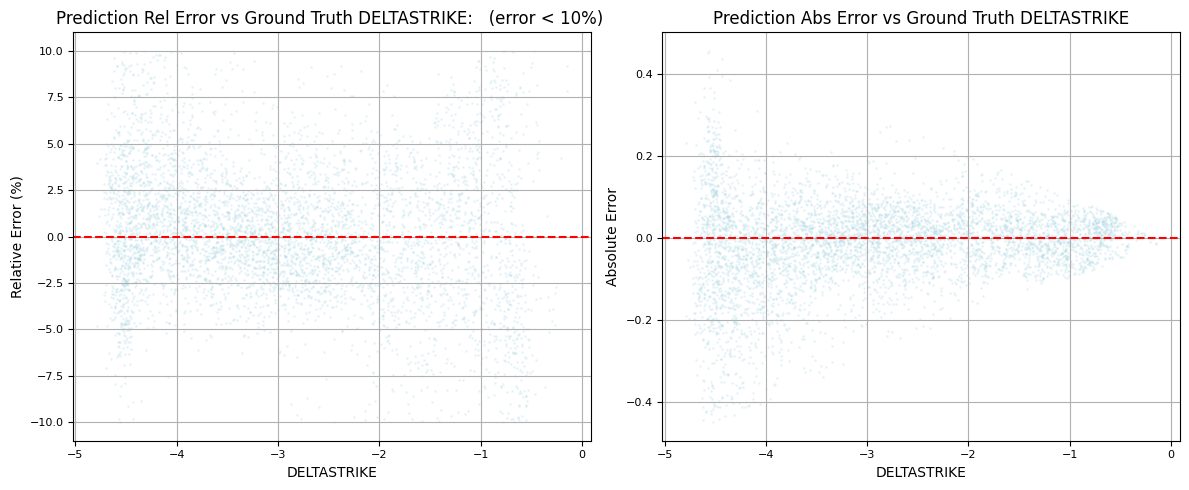

,mtm_bin,diff_rel
0,"(-4.81, -4.273]",1.500254
1,"(-4.273, -3.735]",2.361590
2,"(-3.735, -3.198]",0.521439
3,"(-3.198, -2.66]",0.071809
4,"(-2.66, -2.123]",-0.620373
5,"(-2.123, -1.586]",-3.057800
6,"(-1.586, -1.048]",-3.990554
7,"(-1.048, -0.511]",-0.541760
8,"(-0.511, -0.0055]",-18.865002


In [138]:
# Mean percentage prediction error across MtM bins 
df_deltastrike['y_test'] = df_deltastrike['deltastrike_true']
bin_errors = plot_pred_error_rel_twice(df_deltastrike, df_deltastrike, 'opt_deltastrike', 'Prediction Rel Error vs Ground Truth DELTASTRIKE ', 'Prediction Abs Error vs Ground Truth DELTASTRIKE', x='DELTASTRIKE Bin')

# Relative and absolute prediction errors (no bins) 
df = df_deltastrike[abs(df_deltastrike['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'opt_deltastrike', 'Prediction Rel Error vs Ground Truth DELTASTRIKE:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth DELTASTRIKE', size = 1, x='DELTASTRIKE')
bin_errors[0]

### Vega


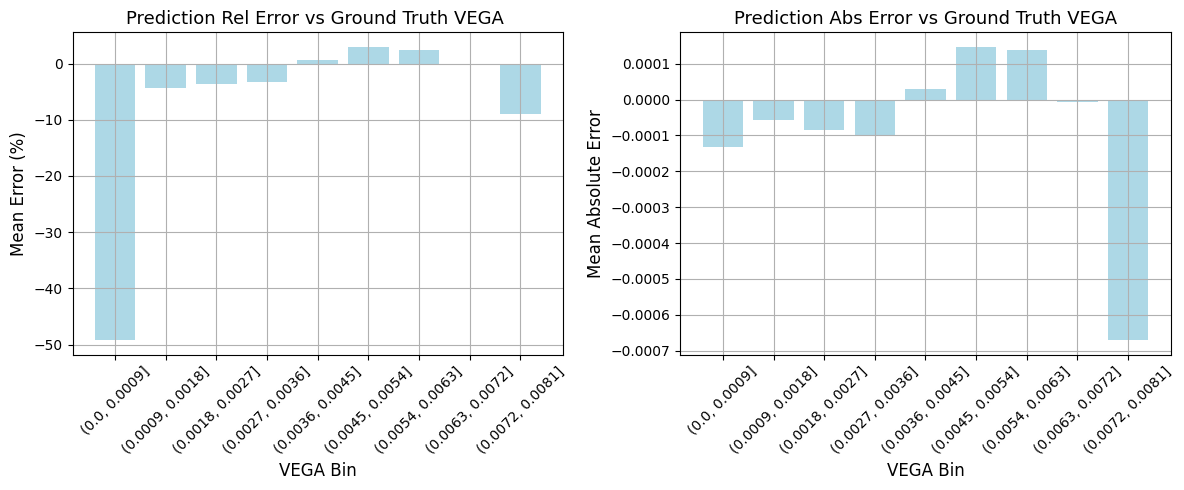

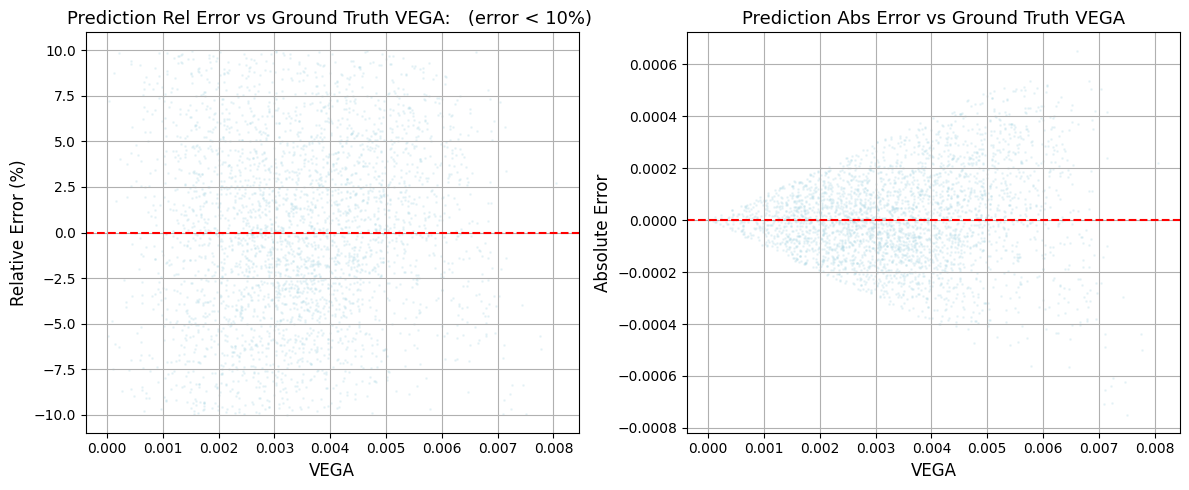

,mtm_bin,diff_rel
0,"(0.0, 0.0009]",-49.170892
1,"(0.0009, 0.0018]",-4.343607
2,"(0.0018, 0.0027]",-3.657977
3,"(0.0027, 0.0036]",-3.218147
4,"(0.0036, 0.0045]",0.641798
5,"(0.0045, 0.0054]",2.948704
6,"(0.0054, 0.0063]",2.399035
7,"(0.0063, 0.0072]",-0.044110
8,"(0.0072, 0.0081]",-8.985619


In [173]:
# Mean percentage prediction error across MtM bins 
df_vega['y_test'] = df_vega['vega_true']
bin_errors = plot_pred_error_rel_twice(df_vega, df_vega, 'opt_vega', 'Prediction Rel Error vs Ground Truth VEGA ', 'Prediction Abs Error vs Ground Truth VEGA', x='VEGA Bin')

# Relative and absolute prediction errors (no bins) 
df = df_vega[abs(df_vega['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'opt_vega', 'Prediction Rel Error vs Ground Truth VEGA:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth VEGA', size = 1, x='VEGA')
bin_errors[0]

## Reconstruct Data for Error Bar Processing   

In the following, we reconstruct the original training and test data columns ready for analysing the potential for using **First Order Gradient** empirical error bars (FOG Bars )  
Then, the training set is evaluated to give us prediction accuracy for the gradient predictions on the training points.  
From this information we can then use a nearest neigbour algorithm to join the test data rows to the 'nearest' training data rows.  
This in turn allows us to compareobserve whether the NN model predictions for unseen data samples lie within $FOG^+$ error bar estimates.  
Where  $FOG^+$ are the ground truth first order gradients measured at the training points $\pm$ the NN prediction error of gradients on those points.  

In [204]:
def reconstruct_data(X_train, X_true, y_true, dydx_true, y_pred, dydx_pred, data):
    # Ensure y arrays are converted to Series with the same index as the corresponding X data
    y_true_series = pd.Series(y_true.flatten(), index=X_true.index)
    y_pred_series = pd.Series(y_pred.flatten(), index=X_true.index)
    # Convert dydx_pred to a DataFrame with the same columns as dydx_true
    dydx_pred_df = pd.DataFrame(dydx_pred, index=X_true.index, columns=dydx_true.columns)

    # TRAIN: Reconstruct the training data with all columns originally present in data_orig
    train_indices = X_train.index
    train_data = data.loc[train_indices].copy()
    
    # TRUE: Reconstruct the true and predicted data with extra original columns from data_orig
    true_indices = X_true.index
    true_data = data.loc[true_indices].copy()
    true_data['mtm_pred'] = y_pred_series
    for col in dydx_pred_df.columns:
        true_data[col + '_pred'] = dydx_pred_df[col]

    return train_data, true_data


train_data, true_data = reconstruct_data(X_train, X_true, y_true, dydx_true, y_pred, dydx_pred, data_orig)

In [205]:
# Evaluate the training data in order to get training gradient uncertainty at the training space points 
y_train_pred, dydx_train_pred = predict_unscaled(model, prep_layer, X_train.values)
y_train_pred_series = pd.Series(y_train_pred.flatten(), index=X_train.index)
train_data['mtm_pred'] = y_train_pred

# Merge with train_data 
dydx_train_pred_df = pd.DataFrame(dydx_train_pred, index=X_train.index, columns=dydx_train.columns)
for col in dydx_train_pred_df.columns:
    train_data[col + '_pred'] = dydx_train_pred_df[col]


740/740 [==============================] - 1s 1ms/step


### Data Sanity Check Visualisation

In [142]:
train_data

,val_date,contractId,optionType,currency,coupon,recovery,indexFactor,indexLoss,maturity,expiryDate,...,delta,theta,deltastrike,vega,deltalogm,mtm_pred,delta_pred,theta_pred,deltastrike_pred,vega_pred
1061807,2024-06-13,CDSO_549983,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,1.655851,0.028874,-0.739315,0.006496,-0.014941,0.005056,1.655797,0.032817,-0.748465,0.007254
1047509,2024-06-13,CDSO_235769,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,3.407603,0.015370,-2.686281,0.004413,-0.022593,0.007391,3.404705,0.014949,-2.676278,0.004332
1037217,2024-06-13,CDSO_8813,1,EUR,100,0.4,1,0,2029-06-20,2024-07-17,...,3.306657,0.029089,-2.270761,0.002497,-0.016640,0.006900,3.316458,0.023779,-2.263796,0.002642
2599859,2024-07-11,CDSO_260579,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,2.654167,0.020552,-2.080526,0.004122,-0.018141,0.004024,2.808789,0.019458,-2.203613,0.004080
1901607,2024-06-27,CDSO_27743,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,4.659330,0.005239,-4.555828,0.000045,-0.024405,0.007361,4.244600,0.003794,-4.702051,-0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593615,2024-07-11,CDSO_54647,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,4.453163,0.007325,-4.300126,0.000691,-0.024361,0.008592,4.397597,0.005055,-4.346650,0.000629
523597,2024-06-06,CDSO_113993,1,EUR,100,0.4,1,0,2029-06-20,2024-06-19,...,1.297813,0.033598,-0.940970,0.001749,-0.007585,0.000872,1.411764,0.036028,-0.996856,0.002318
5193,2024-05-30,CDSO_113621,1,EUR,100,0.4,1,0,2029-06-20,2024-07-17,...,1.995767,0.019052,-1.283433,0.003924,-0.011665,0.002592,2.218990,0.022645,-1.294888,0.004451
1572257,2024-06-20,CDSO_563453,1,EUR,100,0.4,1,0,2029-06-20,2024-07-17,...,2.771642,0.032394,-2.332759,0.004393,-0.025608,0.004933,2.720526,0.030191,-2.285194,0.004221


In [125]:
true_data

,val_date,contractId,optionType,currency,coupon,recovery,indexFactor,indexLoss,maturity,expiryDate,...,delta,theta,deltastrike,vega,deltalogm,mtm_pred,delta_pred,theta_pred,deltastrike_pred,vega_pred
519737,2024-06-06,CDSO_29453,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,2.357292,0.008254,-1.850099,0.004546,-0.012350,0.001862,2.768640,0.008193,-2.131113,0.004985
544607,2024-06-06,CDSO_576023,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,2.659804,0.031243,-1.476091,0.007244,-0.024572,0.010247,2.598983,0.026603,-1.442015,0.007029
528779,2024-06-06,CDSO_227579,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,3.778487,0.021921,-2.385605,0.003649,-0.025050,0.014960,3.820013,0.022050,-2.414780,0.004253
537757,2024-06-06,CDSO_425513,1,EUR,100,0.4,1,0,2029-06-20,2024-06-19,...,2.284848,0.057229,-1.847586,0.002879,-0.018855,0.003253,2.107745,0.059034,-1.721949,0.002472
1052691,2024-06-13,CDSO_349355,1,EUR,100,0.4,1,0,2029-06-20,2024-07-17,...,1.267209,0.034303,-0.617283,0.003552,-0.009687,0.002432,1.268206,0.033507,-0.614059,0.003156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557715,2024-06-20,CDSO_83027,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,4.016588,0.016652,-3.018344,0.002373,-0.022667,0.012698,3.973789,0.016968,-2.971674,0.002497
1051725,2024-06-13,CDSO_328217,1,EUR,100,0.4,1,0,2029-06-20,2024-07-17,...,1.051015,0.026867,-0.530695,0.003155,-0.007830,0.001748,1.037139,0.026949,-0.520304,0.002877
1061453,2024-06-13,CDSO_542081,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,3.497232,0.030139,-2.314289,0.005240,-0.031555,0.016480,3.375434,0.028008,-2.267604,0.005339
3112851,2024-07-25,CDSO_163235,1,EUR,100,0.4,1,0,2029-06-20,2024-08-21,...,4.558302,0.006062,-4.608842,0.000026,-0.028489,0.017439,4.588472,0.002672,-4.743252,-0.000321


In [143]:
# Save to CSV file
#train_data.to_csv('py_opt_train_data.csv', index=False)
#true_data.to_csv('py_opt_true_data.csv', index=False)

## Process the FOG Error Bars  

Calculate the $FOG^+$ error bars and plot how many MtM values fall within these error bar estimates.  

     val_date   contractId  optionType currency  coupon  recovery  \
1  2024-06-06  CDSO_494183           1      EUR     100       0.4   
2  2024-06-06  CDSO_248699           1      EUR     100       0.4   
3  2024-08-08  CDSO_427481           1      EUR     100       0.4   
4  2024-07-18  CDSO_350573           1      EUR     100       0.4   

   indexFactor  indexLoss    maturity  expiryDate  ...  gt_nn_error  \
1            1          0  2029-06-20  2024-08-21  ...    -0.086559   
2            1          0  2029-06-20  2024-08-21  ...    -0.570127   
3            1          0  2029-06-20  2024-08-21  ...     0.607879   
4            1          0  2029-06-20  2024-08-21  ...     2.566048   

   gt_fo_error  nn_fo_error  mtm_t_pred_within_nn_error  \
1    -0.109947    -0.196336                        True   
2    -0.071842    -0.638330                        True   
3    -3.026963    -2.433878                        True   
4    -1.589049     1.002729                        True   

  

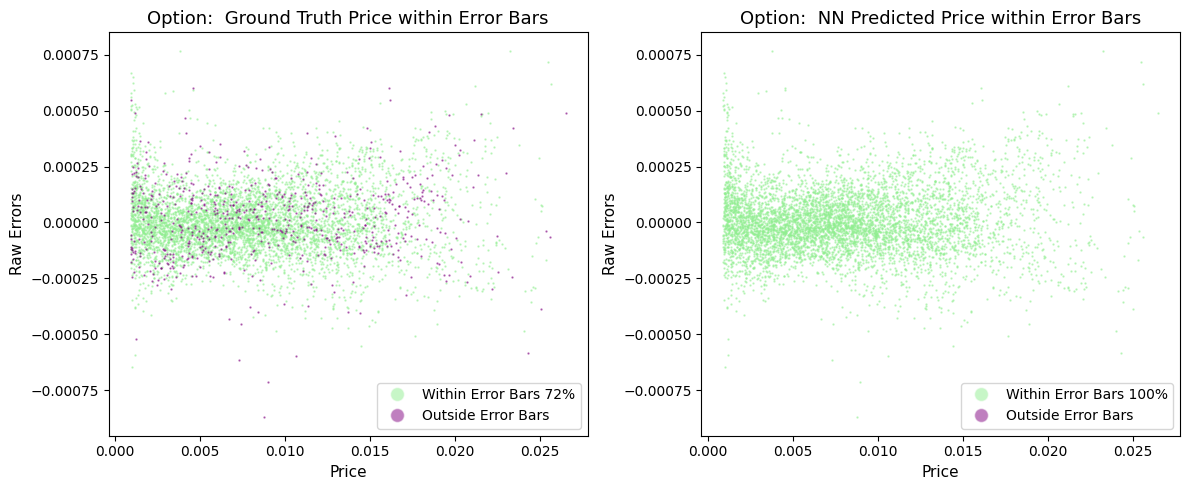

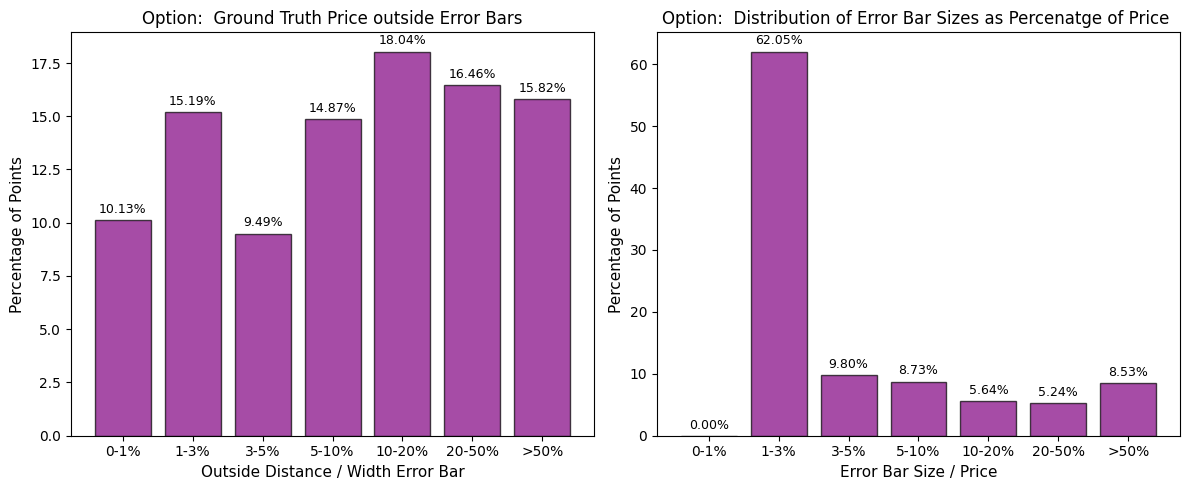

In [206]:
result = error_bars_first_order_estimate_opt(train_data, true_data)
print(result[1:5])
proportion_within_error = result['mtm_t_within_nn_error'].sum() / len(result)
print(f"Proportion of true MtM within error: {proportion_within_error}")

plot_error_bars(result, type='Option: ', within_val_gt='89%', within_val_nn='100%')
plot_true_misses_and_rel_size(result, type='Option: ')